# Zonal temp/salt bias

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41135,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:36971,Total threads: 4
Dashboard: /proxy/33689/status,Memory: 18.29 GiB
Nanny: tcp://127.0.0.1:36729,


In [3]:
# CM2 database
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

In [33]:
# Plotting info
ft_size = 14
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

Load data (previsouly extracted, see code at end of script)

In [7]:
temp_CM2_025 = xr.open_dataarray(path_to_data + 'temp_3d_CM2_025_400_499_mean.nc').load()
temp_CM2_1   = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/temp_3d_CM2_1_400_499_mean.nc').load()
temp_OM2_025 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/temp_3d_OM2_025_2300_2399_mean.nc').load()

In [8]:
temp_CM2_025 = temp_CM2_025.where(temp_CM2_025!=-273.15, np.nan)

In [9]:
salt_CM2_025 = xr.open_dataarray(path_to_data + 'salt_3d_CM2_025_400_499_mean.nc').load()
salt_CM2_1   = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/salt_3d_CM2_1_400_499_mean.nc').load()
salt_OM2_025 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/salt_3d_OM2_025_2300_2399_mean.nc').load()

In [10]:
salt_CM2_025 = salt_CM2_025.where(salt_CM2_025!=0, np.nan)

In [11]:
st_ocean_025 = temp_CM2_025.st_ocean
xt_ocean_025 = temp_CM2_025.xt_ocean
yt_ocean_025 = temp_CM2_025.yt_ocean

In [12]:
st_ocean_1 = temp_CM2_1.st_ocean
xt_ocean_1 = temp_CM2_1.xt_ocean
yt_ocean_1 = temp_CM2_1.yt_ocean

In [19]:
temp_OM2_025['st_ocean'] = st_ocean_025
salt_OM2_025['st_ocean'] = st_ocean_025

WOA13 data

In [13]:
WOA13_025 = xr.open_mfdataset('/g/data/ik11/observations/woa13/025_KDS50/woa13_ts_??_mom025.nc')
WOA13_025 = WOA13_025.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})

In [14]:
WOA13_025['st_ocean'] = st_ocean_025
WOA13_025['xt_ocean'] = xt_ocean_025
WOA13_025['yt_ocean'] = yt_ocean_025

In [15]:
temp_WOA13_025 = WOA13_025.temp.mean('time').load()
salt_WOA13_025 = WOA13_025.salt.mean('time').load()

In [16]:
WOA13_1 = xr.open_mfdataset('/g/data/ik11/observations/woa13/10_KDS50/woa13_ts_??_mom10.nc')
WOA13_1 = WOA13_1.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})

In [17]:
WOA13_1['st_ocean'] = st_ocean_1
WOA13_1['xt_ocean'] = xt_ocean_1
WOA13_1['yt_ocean'] = yt_ocean_1

In [18]:
temp_WOA13_1 = WOA13_1.temp.mean('time').load()
salt_WOA13_1 = WOA13_1.salt.mean('time').load()

Calculate anomalies, then take zonal mean

Zonal mean is not correct north of 65N, ignoring this issue for now.

In [20]:
temp_CM2_025_anom = (temp_CM2_025 - temp_WOA13_025).mean('xt_ocean').load()
temp_CM2_1_anom   = (temp_CM2_1 - temp_WOA13_1).mean('xt_ocean').load()
temp_OM2_025_anom = (temp_OM2_025 - temp_WOA13_025).mean('xt_ocean').load()

In [21]:
salt_CM2_025_anom = (salt_CM2_025 - salt_WOA13_025).mean('xt_ocean').load()
salt_CM2_1_anom   = (salt_CM2_1 - salt_WOA13_1).mean('xt_ocean').load()
salt_OM2_025_anom = (salt_OM2_025 - salt_WOA13_025).mean('xt_ocean').load()

Zonal average for WOA13, need mask from ocean model

In [39]:
mask = temp_CM2_025.copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!

temp_WOA13_025_mask = temp_WOA13_025*mask
zonal_temp_WOA13_025 = temp_WOA13_025_mask.mean('xt_ocean')

salt_WOA13_025_mask = salt_WOA13_025*mask
zonal_salt_WOA13_025 = salt_WOA13_025_mask.mean('xt_ocean')

### Plotting

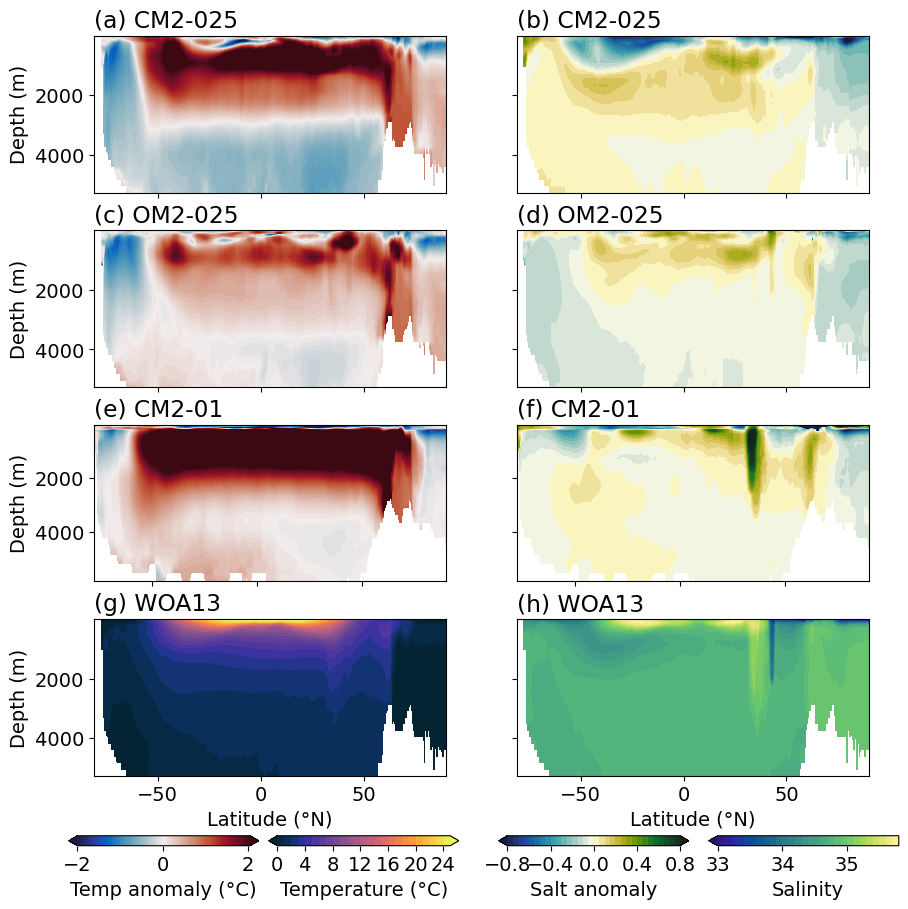

In [44]:
plt.figure(figsize=(10,10))
clev=np.arange(-2,2.1,0.05)
clev2=np.arange(-0.8,0.81,0.05)
    
plt.subplot(421)
p1=temp_CM2_025_anom.plot.contourf(cmap=cm.cm.balance, levels=clev, yincrease=False, add_colorbar=False)
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('(a) CM2-025', loc='left')
plt.tick_params(labelbottom=False)

plt.subplot(422)
s1=salt_CM2_025_anom.plot.contourf(cmap=cm.cm.delta, levels=clev2, yincrease=False, add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(b) CM2-025', loc='left')
plt.tick_params(labelbottom=False, labelleft=False)

plt.subplot(423)
p2=temp_OM2_025_anom.plot.contourf(cmap=cm.cm.balance, levels=clev, yincrease=False, add_colorbar=False)
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('(c) OM2-025', loc='left')
plt.tick_params(labelbottom=False)

plt.subplot(424)
s2=salt_OM2_025_anom.plot.contourf(cmap=cm.cm.delta, levels=clev2, yincrease=False, add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(d) OM2-025', loc='left')
plt.tick_params(labelbottom=False, labelleft=False)

plt.subplot(425)
p3=temp_CM2_1_anom.plot.contourf(cmap=cm.cm.balance, levels=clev, yincrease=False, add_colorbar=False)
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('(e) CM2-01', loc='left')
plt.tick_params(labelbottom=False)

plt.subplot(426)
s3=salt_CM2_1_anom.plot.contourf(cmap=cm.cm.delta, levels=clev2, yincrease=False, add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(f) CM2-01', loc='left')
plt.tick_params(labelbottom=False, labelleft=False)

plt.subplot(427)
p4=zonal_temp_WOA13_025.plot.contourf(cmap=cm.cm.thermal, levels=np.arange(0,26,1), yincrease=False, add_colorbar=False)
plt.xlabel('Latitude (°N)')
plt.ylabel('Depth (m)')
plt.title('(g) WOA13', loc='left')

plt.subplot(428)
s4=zonal_salt_WOA13_025.plot.contourf(cmap=cm.cm.haline, levels=np.arange(33,35.81,0.1), yincrease=False, add_colorbar=False)
plt.xlabel('Latitude (°N)')
plt.ylabel('')
plt.title('(h) WOA13', loc='left')
plt.tick_params(labelleft=False)

plt.subplots_adjust(bottom=0.14,hspace=0.24)

# Colorbars
ax1 = plt.axes([0.1,0.07,0.19,0.01])
cb1 = plt.colorbar(p1, cax=ax1, orientation='horizontal', ticks=[-2, 0, 2])
#ax1.xaxis.set_label_position("top")
cb1.set_label('Temp anomaly (°C)')

ax2 = plt.axes([0.3,0.07,0.19,0.01])
cb2 = plt.colorbar(p4, cax=ax2, orientation='horizontal', ticks=np.arange(0, 25, 4))
#ax1.xaxis.set_label_position("top")
cb2.set_label('Temperature (°C)')

ax3 = plt.axes([0.53,0.07,0.19,0.01])
cb3 = plt.colorbar(s1, cax=ax3, orientation='horizontal', ticks=[-0.8, -0.4, 0, 0.4, 0.8])
#ax1.xaxis.set_label_position("top")
cb3.set_label('Salt anomaly') #(g/kg)

ax4 = plt.axes([0.74,0.07,0.19,0.01])
cb4 = plt.colorbar(s4, cax=ax4, orientation='horizontal', ticks=[33, 34, 35])
#ax1.xaxis.set_label_position("top")
cb4.set_label('Salinity') #  (g/kg)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_temp_salt_zonal_bias.png'
    plt.savefig(fig_path + fig_name, dpi=300);

In [ ]:
# zonal_temp_anom_10.plot(yincrease=False)

In [ ]:
# IPython.display.clear_output()

---
### Calculate and save time-mean data

In [7]:
start_time = '0400-01-01'
end_time   = '0499-12-31'

Temperature

In [ ]:
temp_CM2_025 = cc.querying.getvar(expt_CM2_025, 'temp', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly')# - 273.15
temp_CM2_025 = temp_CM2_025.sel(time=slice(start_time,end_time))

In [38]:
temp_CM2_025.mean('time').to_netcdf(path_to_data + 'temp_3d_CM2_025_400_499_mean.nc')

In [ ]:
temp_CM2_1 = cc.querying.getvar(expt_CM2_1, 'temp', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly') - 273.15
temp_CM2_1 = temp_CM2_1.sel(time=slice(start_time,end_time))

In [25]:
temp_CM2_1.mean('time').to_netcdf(path_to_data + 'Comparison_ACCESS_CM2_1/temp_3d_CM2_1_400_499_mean.nc')

In [ ]:
temp_OM2_025 = cc.querying.getvar(expt_OM2_025, 'temp', session_OM2, start_time='2300-01-01', end_time='2399-12-31', frequency='1 monthly') - 273.15
temp_OM2_025 = temp_OM2_025.sel(time=slice('2300-01-01','2399-12-31'))

In [98]:
temp_OM2_025.mean('time').to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/temp_3d_OM2_025_2300_2399_mean.nc')

Salinity

In [ ]:
salt_CM2_025 = cc.querying.getvar(expt_CM2_025, 'salt', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly')
salt_CM2_025 = salt_CM2_025.sel(time=slice(start_time,end_time))

In [40]:
salt_CM2_025.mean('time').to_netcdf(path_to_data + 'salt_3d_CM2_025_400_499_mean.nc')

In [ ]:
salt_CM2_1 = cc.querying.getvar(expt_CM2_1, 'salt', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly')
salt_CM2_1 = salt_CM2_1.sel(time=slice(start_time,end_time))

In [42]:
salt_CM2_1.mean('time').to_netcdf(path_to_data + 'Comparison_ACCESS_CM2_1/salt_3d_CM2_1_400_499_mean.nc')

In [ ]:
salt_OM2_025 = cc.querying.getvar(expt_OM2_025, 'salt', session_OM2, start_time='2300-01-01', end_time='2399-12-31', frequency='1 monthly')
salt_OM2_025 = salt_OM2_025.sel(time=slice('2300-01-01','2399-12-31'))

In [9]:
salt_OM2_025.mean('time').to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/salt_3d_OM2_025_2300_2399_mean.nc')

In [93]:
temp_OM2_025 = cc.querying.getvar(expt_OM2_025, 'temp', session_OM2, start_time='2399-01-01', end_time='2399-12-31', frequency='1 monthly') - 273.15

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [94]:
temp_OM2_025 = temp_OM2_025.sel(time=slice('2399-01-01','2399-12-31'))

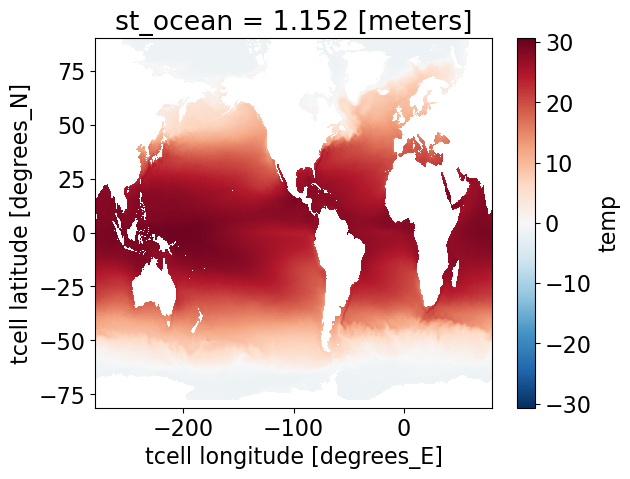

In [95]:
temp_OM2_025.mean('time').sel(st_ocean=0, method='nearest').plot()